In [1]:
import numpy as np
import pandas as pd
import warnings; warnings.simplefilter('ignore')

In [2]:
# plotting
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

In [3]:
import pandas.io.data as web
#from pandas_datareader import data as web
import pandas_datareader as pdr

In [4]:
path='/home/octo/Desktop/PyCon2016/'

In [5]:
#pdr.get_data_yahoo('NIFTYBEES.NS')
NB = web.DataReader(name='NIFTYBEES.NS', data_source='yahoo',start='2008-1-1')
NB.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1924 entries, 2008-01-01 to 2016-07-14
Data columns (total 6 columns):
Open         1924 non-null float64
High         1924 non-null float64
Low          1924 non-null float64
Close        1924 non-null float64
Volume       1924 non-null int64
Adj Close    1924 non-null float64
dtypes: float64(5), int64(1)
memory usage: 105.2 KB


In [6]:
NB['Open Change']= np.where(NB['Open']>NB['Close'].shift(1),1,np.where(NB['Open']<NB['Close'].shift(1),-1,0))

In [61]:
NB['Change'] = np.sign(np.log(NB['Open'] /NB['Close'].shift(1)))

In [7]:
#NB['Close Change'] = np.where(NB['Close']>NB['Close'].shift(1),1,np.where(NB['Close']<NB['Close'].shift(1),-1,0))

In [8]:
#NB['direction']=np.where(np.logical_and(NB['Open Change']==1,NB['Close Change'].shift(1)==1),1,np.where(np.logical_and(NB['Open Change']==-1,NB['Close Change'].shift(1)==-1),-1,0))

In [9]:
NB['Volume']=NB['Volume']/pd.rolling_mean(NB['Volume'],10)

In [10]:
#NB['Volatility']= np.where(pd.rolling_std(NB['Close'],42)>20,1,np.where(pd.rolling_std(NB['Close'],42)<-20,-1,0))
NB['Volatility']=NB['Close'].apply(lambda x: np.log(x))/pd.rolling_std(NB['Close'],21)

In [11]:
flagD=np.logical_and(np.logical_and(NB['Open'].shift(2)<NB['Close'].shift(3),NB['Open'].shift(1)< NB['Close'].shift(2)),NB['Open']< NB['Close'].shift(1))
flagU=np.logical_and(np.logical_and(NB['Open'].shift(2)>NB['Close'].shift(3),NB['Open'].shift(1)> NB['Close'].shift(2)),NB['Open']> NB['Close'].shift(1))

In [12]:
NB['3UD']= np.where(flagU,-1,np.where(flagD,1,0))

In [62]:
NB['BS1']=np.where(np.logical_and(NB['3UD'].shift(1)==1,NB['Open Change']==-1),-1,np.where(np.logical_and(NB['3UD'].shift(1)==-1,NB['Open Change']==1),1,0))

In [14]:
import TA# self made python file at PyCON16 folder for TA
#https://mrjbq7.github.io/ta-lib/func.html
import talib

In [85]:
#Calculating momentum of the close prices, with a time period of 5:
#NB['momentum'] = np.where(talib.MOM(np.asarray(NB['Close']), timeperiod=14)>30,1,np.where(talib.MOM(np.asarray(NB['Close']), timeperiod=14)<-30,-1,0))
NB['momentum'] = talib.MOM(np.asarray(NB['Close']), timeperiod=14)

In [84]:
#NB['RSI'] = np.where(talib.RSI(np.asarray(NB['Close']), timeperiod=14)>60,1,np.where(talib.RSI(np.asarray(NB['Close']), timeperiod=14)<45,-1,0))
NB['RSI'] = talib.RSI(np.asarray(NB['Close']), timeperiod=14)

In [17]:
  # reads data from Google Finance
NB['14d'] = pd.rolling_mean(NB['Close'], 14)
NB['42d'] = pd.rolling_mean(NB['Close'], 42)
  # 42d and 252d trends
NB['Cross']=np.where(NB['14d']>NB['42d'], 1,np.where(NB['14d']<NB['42d'],-1,0))

In [18]:
NB['BS2']=np.where(np.logical_and(np.logical_and(NB['momentum']==1,NB['RSI']==1),NB['Cross']==1),-1,np.where(np.logical_and(np.logical_and(NB['momentum']==-1,NB['RSI']==-1),NB['Cross']==-1),1,0))

In [90]:
NB=NB.dropna()

In [93]:
#X=NB[['BS2','3UD']]#'Volume','Volatility' to be chked later
X=NB[['momentum','RSI']]

In [94]:
y=NB[['Open Change']]

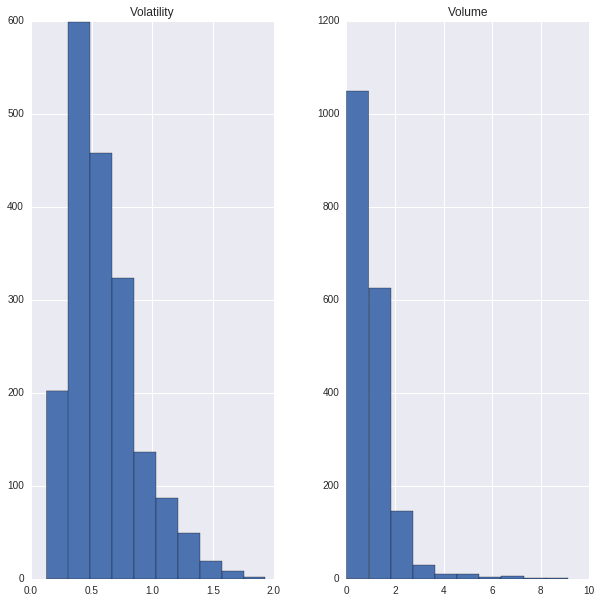

In [65]:
pd.DataFrame.hist(X, figsize = [10,10]);

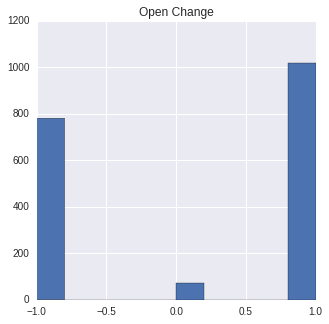

In [106]:
pd.DataFrame.hist(y, figsize = [5,5]);

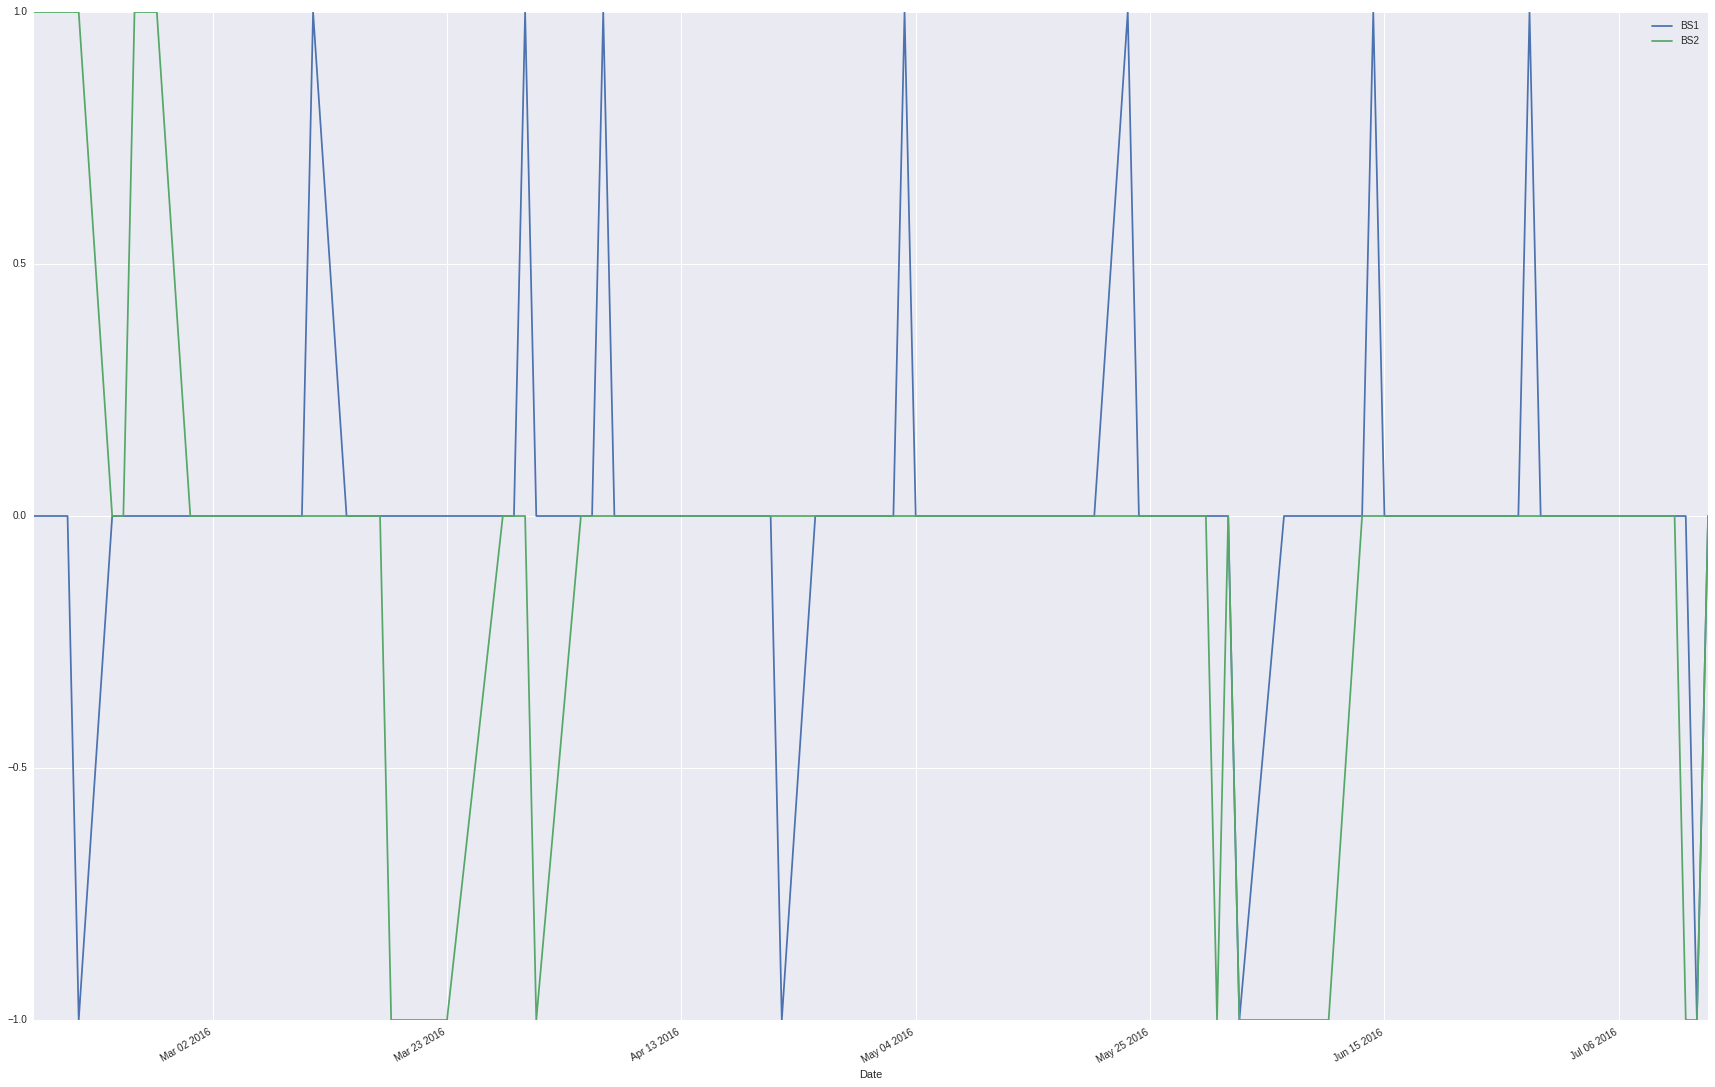

In [118]:
NB[['BS1','BS2']].tail(100).plot(figsize=(30,20), grid=True);

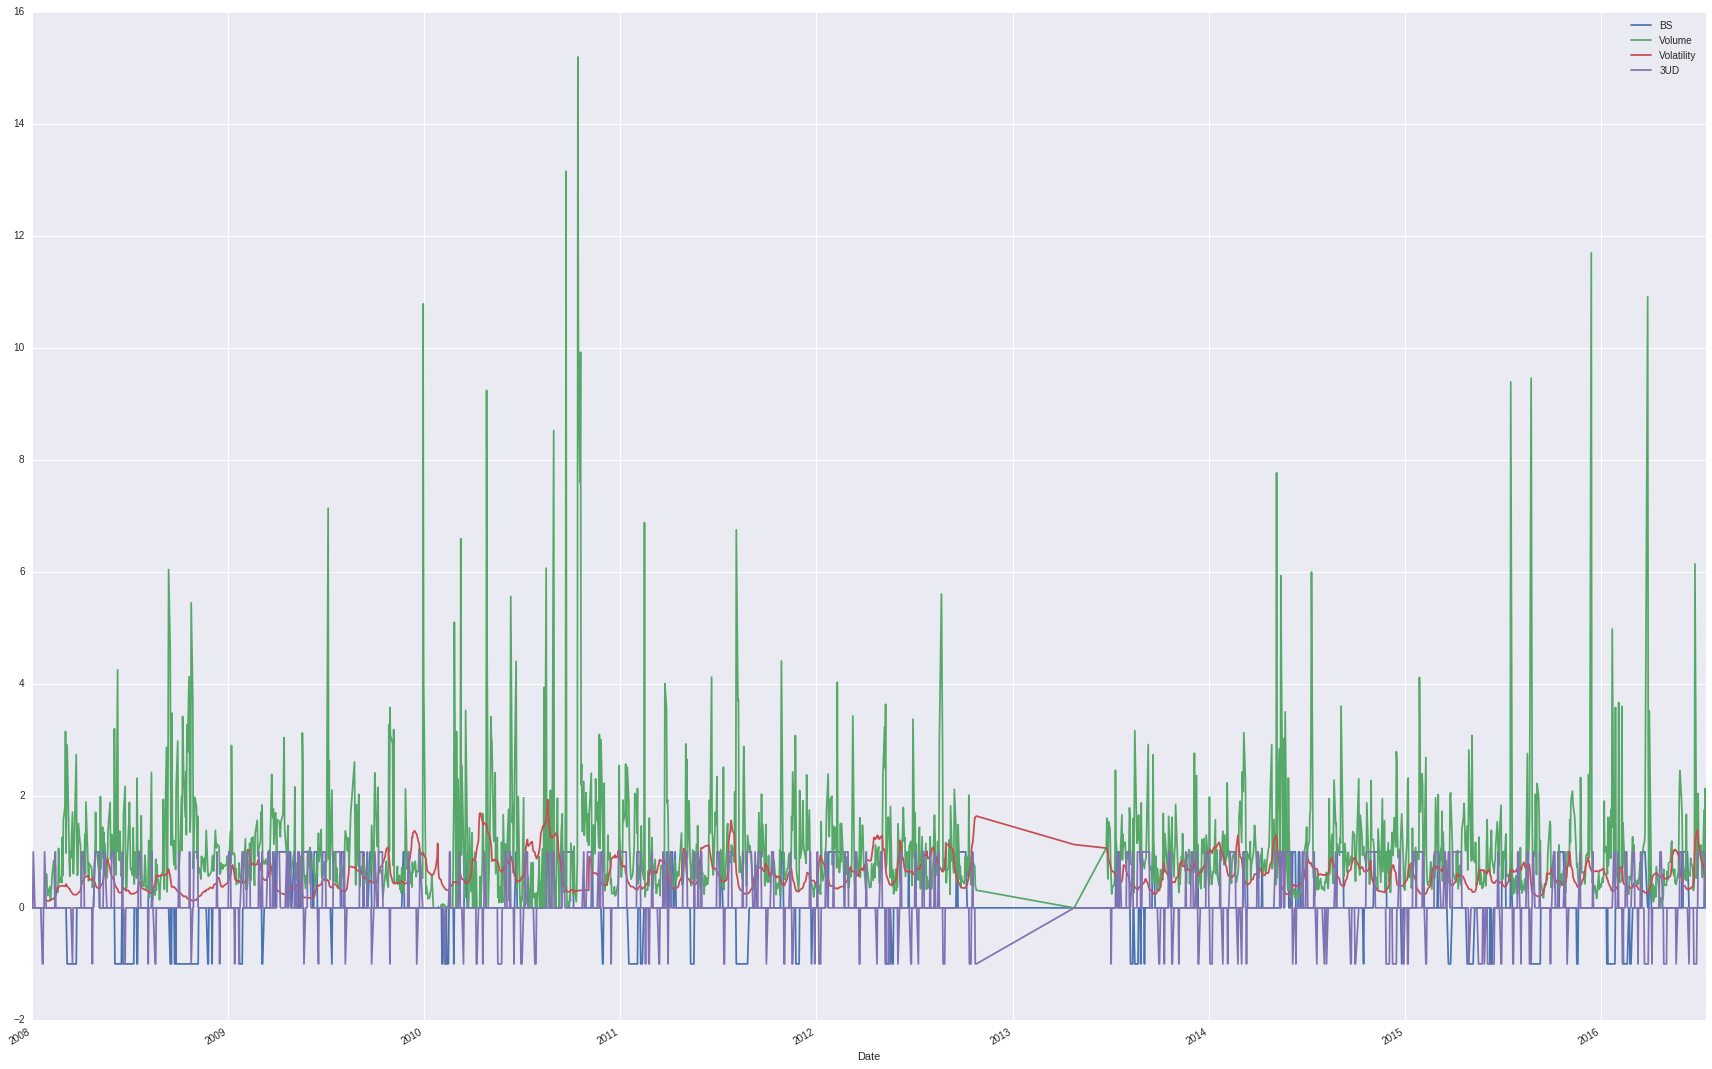

In [40]:
NB[['BS', 'Volume','Volatility','3UD']].plot(figsize=(30,20), grid=True);

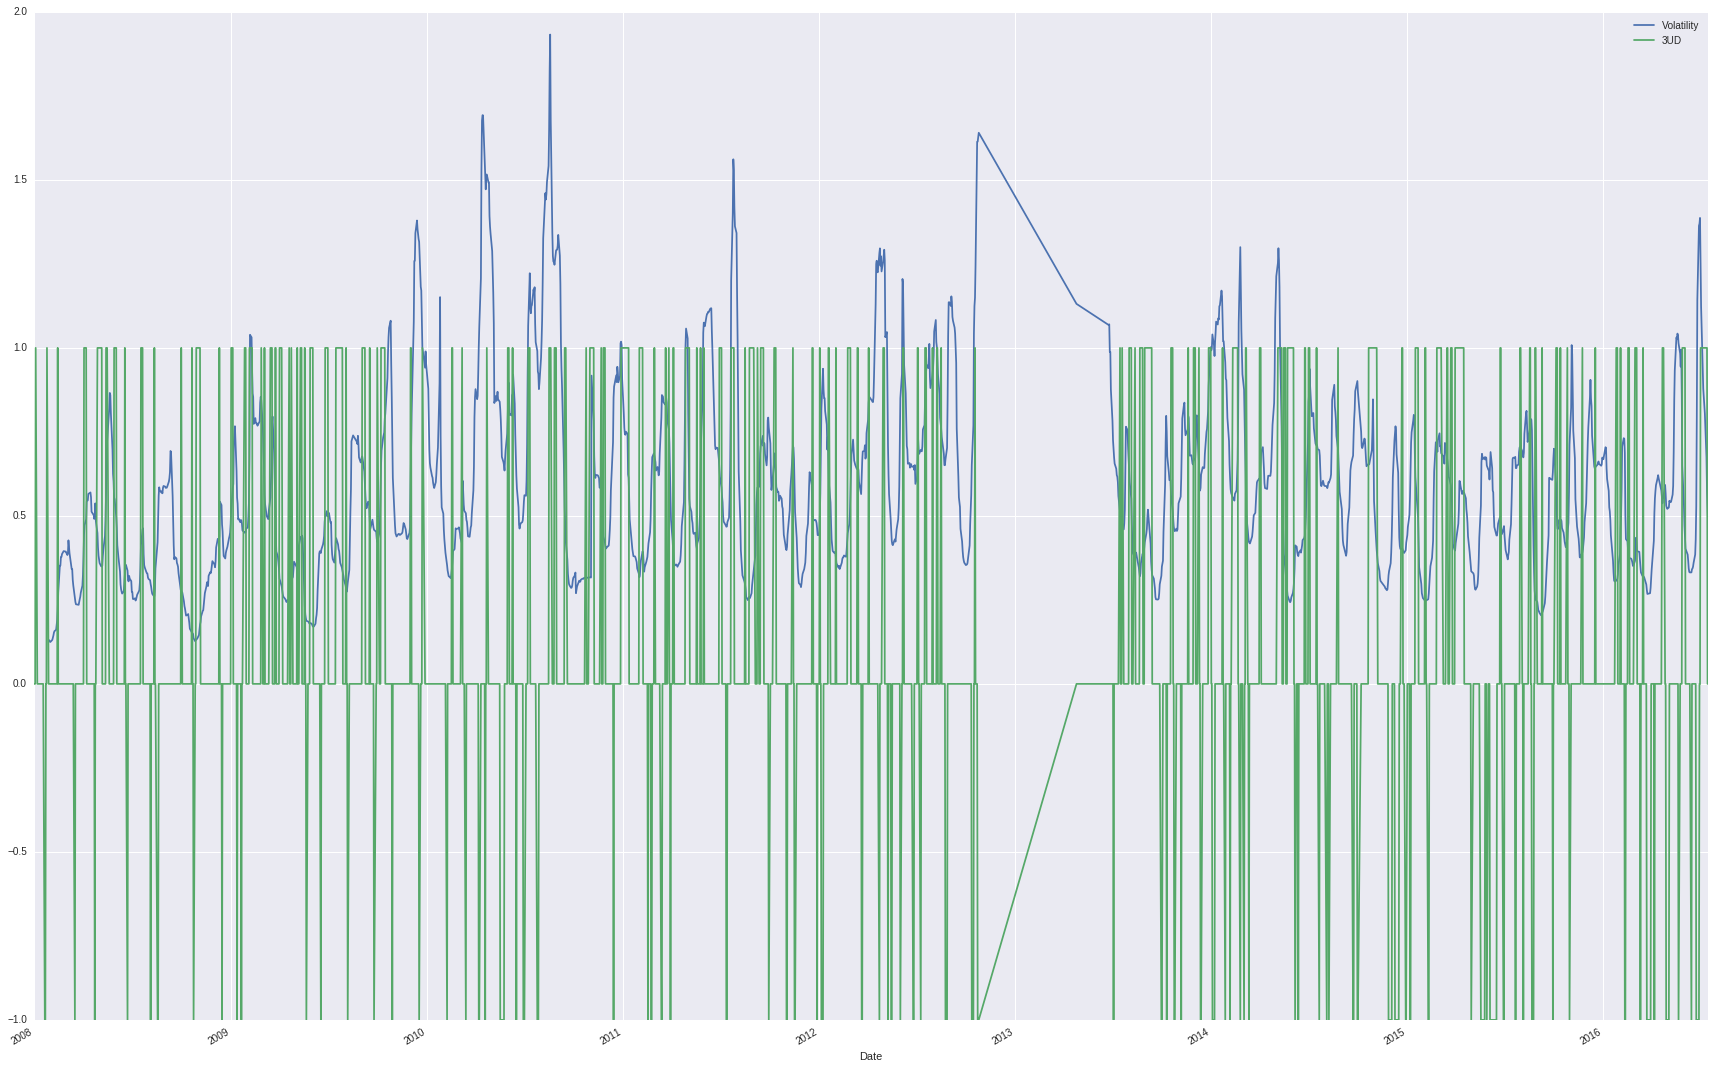

In [44]:
NB[['Volatility','3UD']].plot(figsize=(30,20), grid=True);

In [95]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:
from sklearn.svm import SVC
svm = SVC(kernel='linear')
svm_model_1 = svm.fit(X_train, y_train)
print('SVC accuracy for test set: %f' % svm_model_1.score(X_test, y_test))

/home/octo/anaconda2/envs/PyAlgo/lib/python2.7/site-packages/sklearn/svm/base.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


SVC accuracy for test set: 0.585561


In [97]:
from sklearn.metrics import classification_report
y_true, y_pred = y_test,svm_model_1.predict(X_test)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

         -1       0.00      0.00      0.00       142
          0       0.00      0.00      0.00        13
          1       0.59      1.00      0.74       219

avg / total       0.34      0.59      0.43       374



In [98]:
from sklearn.preprocessing import scale
Xs = scale(X)
from sklearn.cross_validation import train_test_split
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=42)
svm_model_2 = svm.fit(Xs_train, y_train)
print('SVC for test set: %f' % svm_model_2.score(Xs_test, y_test))
print('SVC for training set: %f' % svm_model_2.score(Xs_train, y_train))
y_true, y_pred = y_test, svm_model_2.predict(Xs_test)
print(classification_report(y_true, y_pred))

SVC for test set: 0.585561
SVC for training set: 0.533779
             precision    recall  f1-score   support

         -1       0.00      0.00      0.00       142
          0       0.00      0.00      0.00        13
          1       0.59      1.00      0.74       219

avg / total       0.34      0.59      0.43       374



/home/octo/anaconda2/envs/PyAlgo/lib/python2.7/site-packages/sklearn/svm/base.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


In [104]:
svm_model_2.decision_function([[10,25]])

array([[ 0.99957575, -0.9974193 , -0.999453  ]])

In [105]:
print(svm_model_2.predict([[30,75]]))

[1]


In [73]:
print(svm_model_2.coef_)

[[ -1.43844374e-05  -3.70866073e-05]
 [  2.12281749e-06   5.02788225e-06]
 [ -6.31578744e-05  -9.68510692e-06]]


In [101]:
X.tail(2)

,momentum,RSI
Date,,
2016-07-13,32.86,71.918319
2016-07-14,29.88,73.594836


In [37]:
y.tail(2)

,Open Change
Date,
2016-07-13,-1
2016-07-14,1


In [51]:
from sklearn import datasets
iris = datasets.load_iris()

In [60]:
iris.data
#iris.target

array([[ 4.7,  3.2,  1.3,  0.2],
       [ 4.6,  3.1,  1.5,  0.2],
       [ 5. ,  3.6,  1.4,  0.2],
       [ 5.4,  3.9,  1.7,  0.4],
       [ 4.6,  3.4,  1.4,  0.3],
       [ 5. ,  3.4,  1.5,  0.2],
       [ 4.4,  2.9,  1.4,  0.2],
       [ 4.9,  3.1,  1.5,  0.1],
       [ 5.4,  3.7,  1.5,  0.2],
       [ 4.8,  3.4,  1.6,  0.2],
       [ 4.8,  3. ,  1.4,  0.1],
       [ 4.3,  3. ,  1.1,  0.1],
       [ 5.8,  4. ,  1.2,  0.2],
       [ 5.7,  4.4,  1.5,  0.4],
       [ 5.4,  3.9,  1.3,  0.4],
       [ 5.1,  3.5,  1.4,  0.3],
       [ 5.7,  3.8,  1.7,  0.3],
       [ 5.1,  3.8,  1.5,  0.3],
       [ 5.4,  3.4,  1.7,  0.2],
       [ 5.1,  3.7,  1.5,  0.4],
       [ 4.6,  3.6,  1. ,  0.2],
       [ 5.1,  3.3,  1.7,  0.5],
       [ 4.8,  3.4,  1.9,  0.2],
       [ 5. ,  3. ,  1.6,  0.2],
       [ 5. ,  3.4,  1.6,  0.4],
       [ 5.2,  3.5,  1.5,  0.2],
       [ 5.2,  3.4,  1.4,  0.2],
       [ 4.7,  3.2,  1.6,  0.2],
       [ 4.8,  3.1,  1.6,  0.2],
       [ 5.4,  3.4,  1.5,  0.4],
       [ 5